In [155]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from wordcloud import STOPWORDS
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
# from google.colab import files
nltk.download('stopwords')
from bs4 import BeautifulSoup
import re
import string

from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, default_data_collator, Trainer, set_seed


import tokenization
from wordcloud import STOPWORDS

from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score, f1_score

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense, Input, Dropout, GlobalAveragePooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from bert import tokenization

SEED = 1337

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Shruti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [156]:
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')

## Exploratory Data Analysis

In [157]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [158]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [159]:
print(df_train.shape)
print(df_test.shape)

(7613, 5)
(3263, 4)


## Missing Values

In [160]:
df_train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [161]:
df_test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

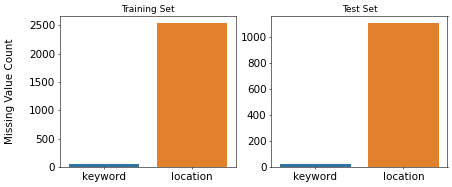

In [162]:
missing_cols = ['keyword', 'location']

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), dpi=50)

sns.barplot(x=df_train[missing_cols].isnull().sum().index, y=df_train[missing_cols].isnull().sum().values, ax=axes[0])
sns.barplot(x=df_test[missing_cols].isnull().sum().index, y=df_test[missing_cols].isnull().sum().values, ax=axes[1])

axes[0].set_ylabel('Missing Value Count', size=15, labelpad=20)
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Training Set', fontsize=13)
axes[1].set_title('Test Set', fontsize=13)

plt.show()

for df in [df_train, df_test]:
    for col in ['keyword', 'location']:
        df[col] = df[col].fillna(f'no_{col}')

0.8% of keyword is missing in both training and test set
33% of location is missing in both training and test set

Since missing value ratios between training and test set are too close, they are most probably taken from the same sample. Missing values in those features are filled with no_keyword and no_location respectively.

In [163]:
df_train.isnull().sum()


id          0
keyword     0
location    0
text        0
target      0
dtype: int64

In [164]:
df_test.isnull().sum()

id          0
keyword     0
location    0
text        0
dtype: int64

### Data Distribution


In [165]:
print(f'Number of unique values in keyword = {df_train["keyword"].nunique()} (Training) - {df_test["keyword"].nunique()} (Test)')
print(f'Number of unique values in location = {df_train["location"].nunique()} (Training) - {df_test["location"].nunique()} (Test)')

Number of unique values in keyword = 222 (Training) - 222 (Test)
Number of unique values in location = 3342 (Training) - 1603 (Test)


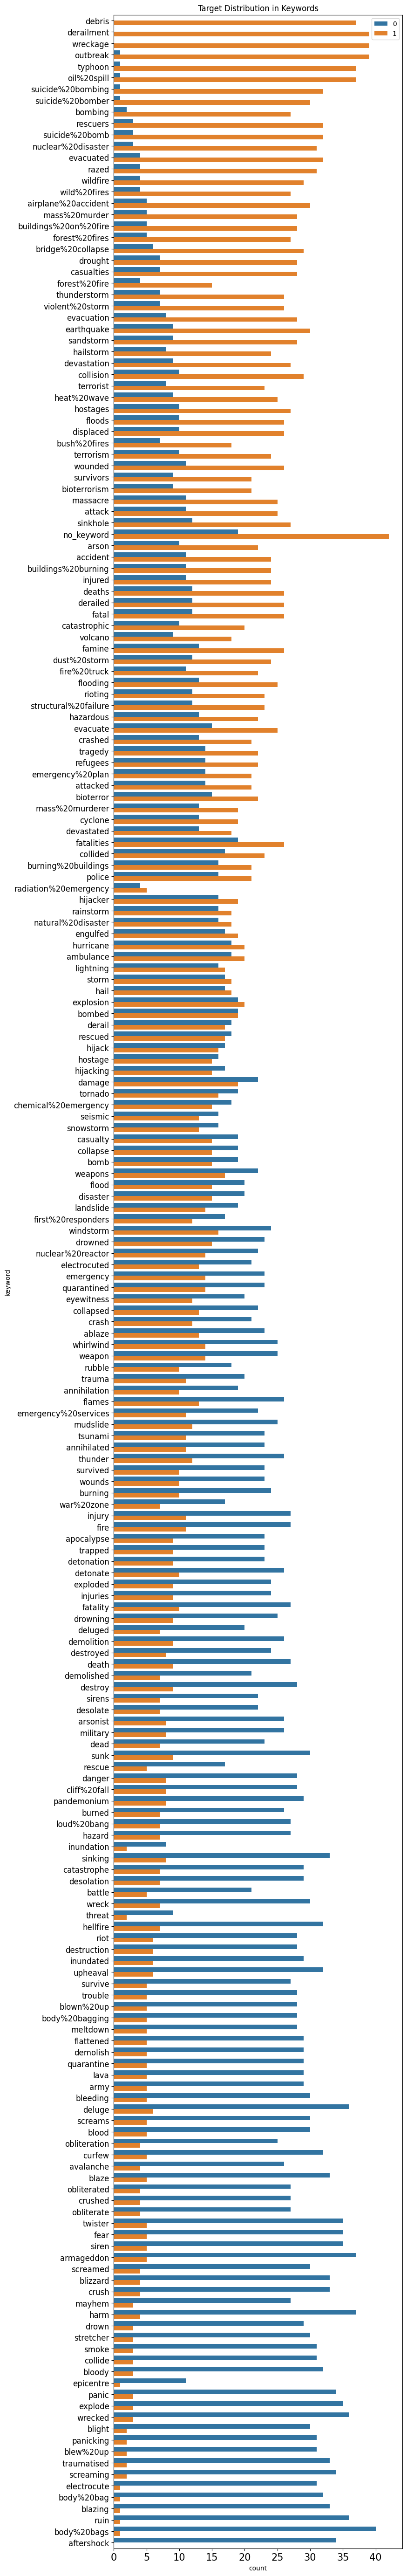

In [166]:
df_train['target_mean'] = df_train.groupby('keyword')['target'].transform('mean')

fig = plt.figure(figsize=(8, 72), dpi=100)

sns.countplot(y=df_train.sort_values(by='target_mean', ascending=False)['keyword'],
              hue=df_train.sort_values(by='target_mean', ascending=False)['target'])

plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=12)
plt.legend(loc=1)
plt.title('Target Distribution in Keywords')

plt.show()

df_train.drop(columns=['target_mean'], inplace=True)

### Distribution of Meta Features in train and Test data

In [167]:
# word_count
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
df_test['word_count'] = df_test['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
df_test['unique_word_count'] = df_test['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
df_train['stop_word_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df_test['stop_word_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
df_train['url_count'] = df_train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df_test['url_count'] = df_test['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
df_train['mean_word_length'] = df_train['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df_test['mean_word_length'] = df_test['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
df_test['char_count'] = df_test['text'].apply(lambda x: len(str(x)))

# punctuation_count
df_train['punctuation_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df_test['punctuation_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
df_train['hashtag_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df_test['hashtag_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
df_train['mention_count'] = df_train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
df_test['mention_count'] = df_test['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

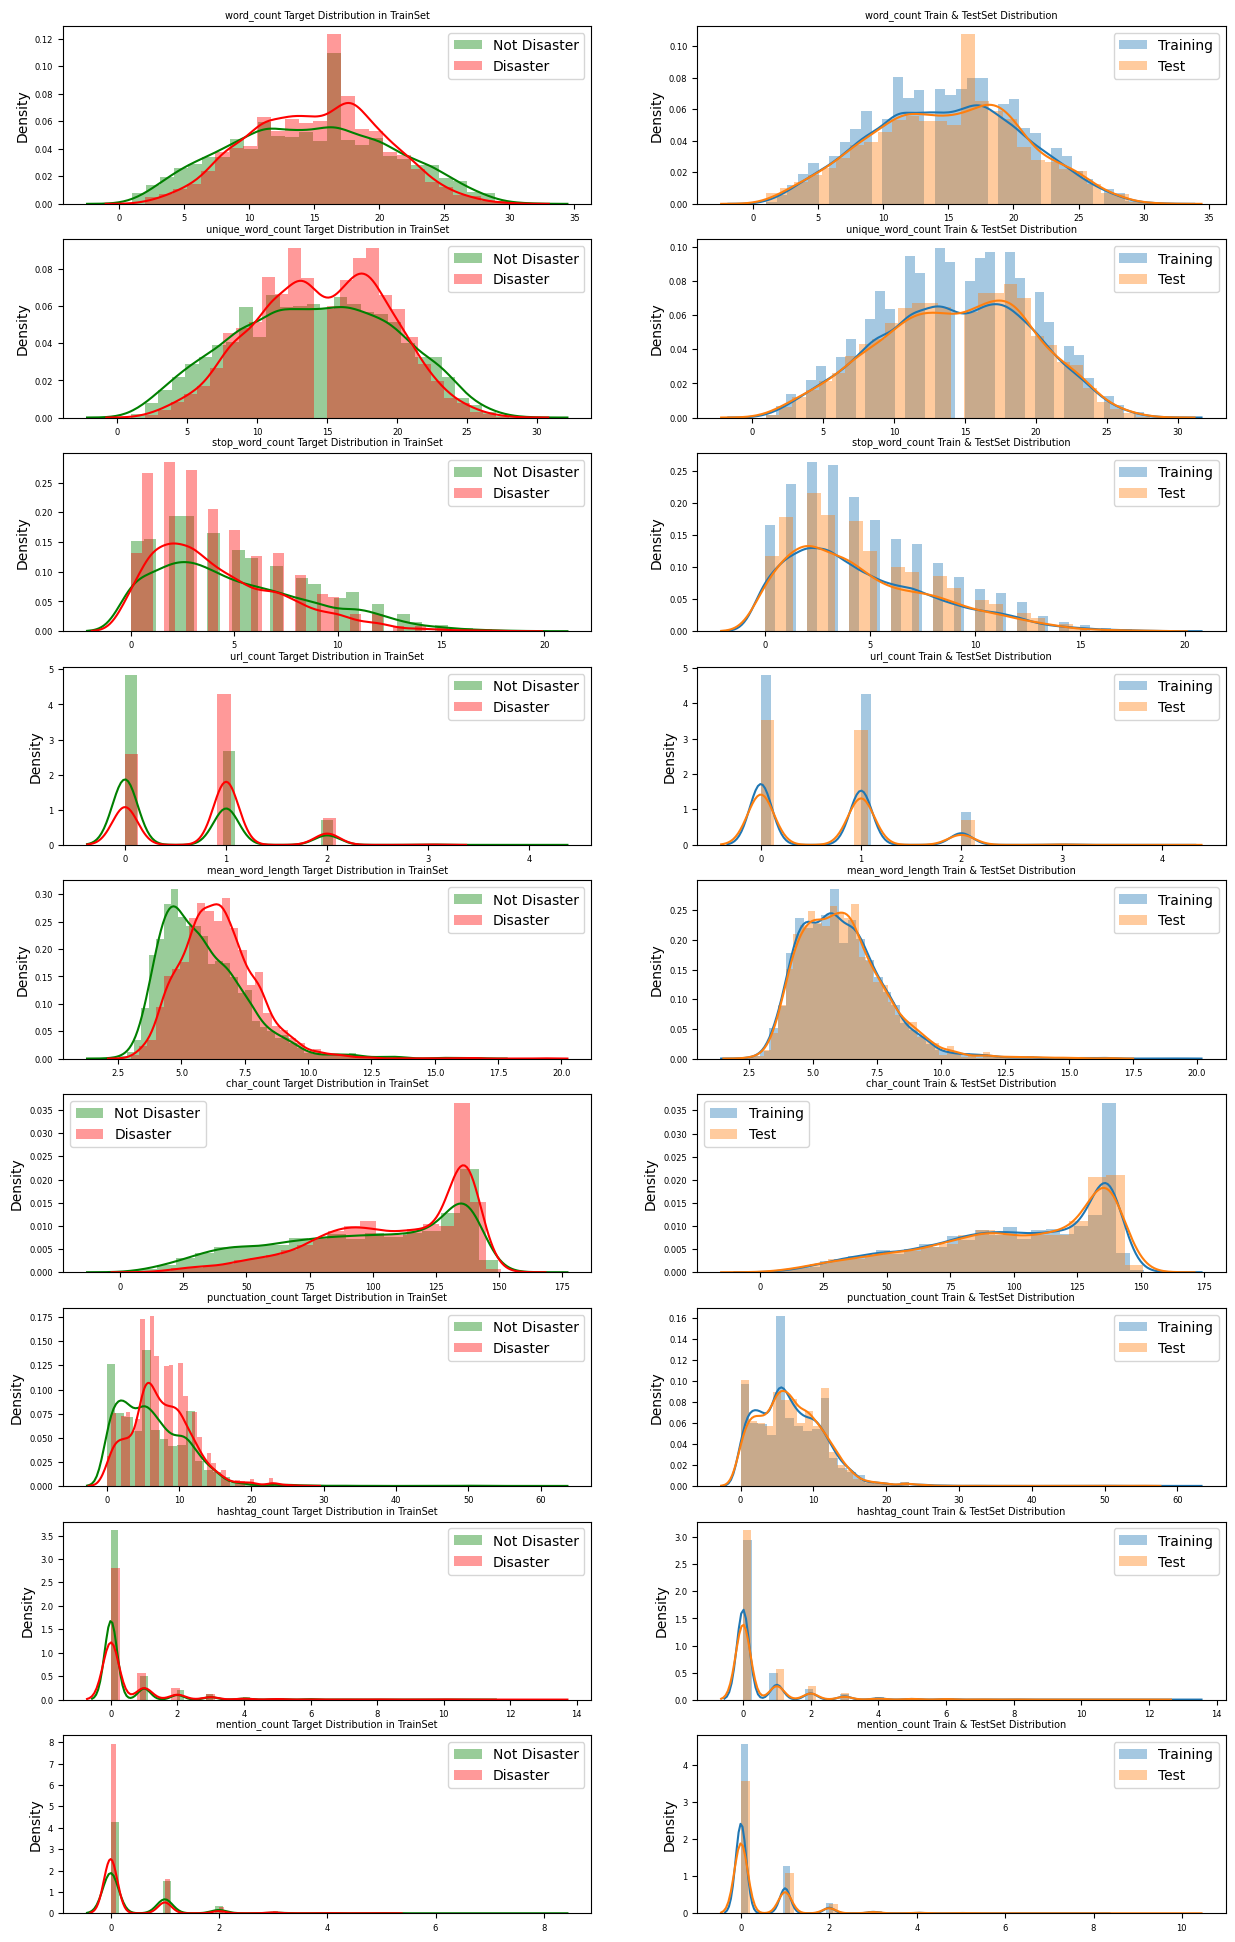

In [168]:
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']
DISASTER_TWEETS = df_train['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(15, 25), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(df_train.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(df_train.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(df_train[feature], label='Training', ax=axes[i][1])
    sns.distplot(df_test[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=6)
        axes[i][j].tick_params(axis='y', labelsize=6)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in TrainSet', fontsize=7)
    axes[i][1].set_title(f'{feature} Train & TestSet Distribution', fontsize=7)

plt.show()

### Target Distribution

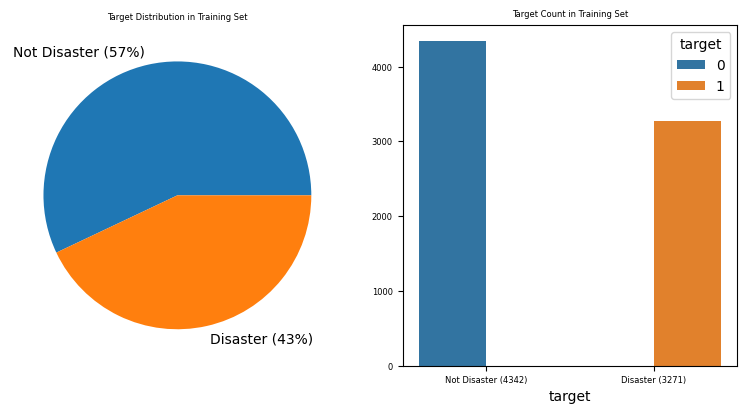

In [169]:
fig, axes = plt.subplots(ncols=2, figsize=(8, 4), dpi=100)
plt.tight_layout()

df_train.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=df_train['target'], hue=df_train['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=6)
axes[0].tick_params(axis='y', labelsize=6)
axes[1].tick_params(axis='x', labelsize=6)
axes[1].tick_params(axis='y', labelsize=6)

axes[0].set_title('Target Distribution in Training Set', fontsize=6)
axes[1].set_title('Target Count in Training Set', fontsize=6)

plt.show()

## Preprocessing

In [170]:
df_train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [171]:
df_train['keyword'].value_counts()

no_keyword               61
fatalities               45
deluge                   42
armageddon               42
sinking                  41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64

In [172]:
df_train['keyword_filled']=df_train['keyword']
df_train['keyword_filled'].fillna(value=' ', inplace=True)

In [173]:
df_train['keyword_filled'].isnull().sum()

0

In [174]:
df_train['key_text']=df_train['keyword_filled']+df_train['text']

In [175]:
df_train.head(5)

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,hashtag_count,mention_count,keyword_filled,key_text
0,1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1,13,13,6,0,4.384615,69,1,1,0,no_keyword,no_keywordOur Deeds are the Reason of this #ea...
1,4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1,7,7,0,0,4.571429,38,1,0,0,no_keyword,no_keywordForest fire near La Ronge Sask. Canada
2,5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1,22,20,11,0,5.090909,133,3,0,0,no_keyword,no_keywordAll residents asked to 'shelter in p...
3,6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1,8,8,1,0,7.125000,65,2,1,0,no_keyword,"no_keyword13,000 people receive #wildfires eva..."
4,7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1,16,15,7,0,4.500000,88,2,2,0,no_keyword,no_keywordJust got sent this photo from Ruby #...


In [176]:
X_train_complete=df_train[['id','key_text','target']]

In [177]:
print(df_train.shape)
print(X_train_complete.shape)

(7613, 16)
(7613, 3)


In [178]:
X_train_complete.head(5)

,id,key_text,target
0,1,no_keywordOur Deeds are the Reason of this #ea...,1
1,4,no_keywordForest fire near La Ronge Sask. Canada,1
2,5,no_keywordAll residents asked to 'shelter in p...,1
3,6,"no_keyword13,000 people receive #wildfires eva...",1
4,7,no_keywordJust got sent this photo from Ruby #...,1


In [179]:
df_test['keyword_filled']=df_test['keyword']
df_test['keyword_filled'].fillna(value=' ', inplace=True)
df_test['keyword_filled'].isnull().sum()
df_test['key_text']=df_test['keyword_filled']+df_test['text']

In [180]:
X_test_complete=df_test[['id','key_text']]

In [181]:
print(df_test.shape)
print(X_test_complete.shape)

(3263, 15)
(3263, 2)


In [182]:
X_test_complete.head(5)

,id,key_text
0,0,no_keywordJust happened a terrible car crash
1,2,no_keywordHeard about #earthquake is different...
2,3,"no_keywordthere is a forest fire at spot pond,..."
3,9,no_keywordApocalypse lighting. #Spokane #wildf...
4,11,no_keywordTyphoon Soudelor kills 28 in China a...


In [183]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [184]:
 # https://stackoverflow.com/questions/34293875/how-to-remove-punctuation-marks-from-a-string-in-python-3-x-using-translate/34294022

def remove_URL(text):
  url = re.compile(r"https?://\S+|www\.\S+")
  return url.sub(r"", text)

def remove_punct(text):
  translator = str.maketrans("", "", string.punctuation)
  return text.translate(translator)

In [185]:
X_train_complete["key_text"] = X_train_complete.key_text.map(remove_URL) 
X_train_complete["key_text"] = X_train_complete.key_text.map(remove_punct)

In [186]:
X_test_complete["key_text"] = X_test_complete.key_text.map(remove_URL) 
X_test_complete["key_text"] = X_test_complete.key_text.map(remove_punct)

In [187]:
#Deduplication of entries

In [188]:
X_train_dd=X_train_complete.drop_duplicates(subset={"key_text"}, keep='first', inplace=False)
# X_test_dd =X_test_complete.drop_duplicates(subset={"key_text"}, keep='first', inplace=False)

In [189]:
X_train_dd.shape

(6999, 3)

In [190]:
# X_test_dd.shape

In [191]:
X_train=X_train_dd.drop(columns='target')
X_test=X_test_complete
Y_train=X_train_dd['target']

In [192]:
X_train.head(5)

,id,key_text
0,1,nokeywordOur Deeds are the Reason of this eart...
1,4,nokeywordForest fire near La Ronge Sask Canada
2,5,nokeywordAll residents asked to shelter in pla...
3,6,nokeyword13000 people receive wildfires evacua...
4,7,nokeywordJust got sent this photo from Ruby Al...


In [193]:
X_test.head(5)

,id,key_text
0,0,nokeywordJust happened a terrible car crash
1,2,nokeywordHeard about earthquake is different c...
2,3,nokeywordthere is a forest fire at spot pond g...
3,9,nokeywordApocalypse lighting Spokane wildfires
4,11,nokeywordTyphoon Soudelor kills 28 in China an...


In [194]:
print(X_train_complete.shape)
print(X_test_complete.shape)
print(X_train_dd.shape)
# print(X_test_dd.shape)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)

(7613, 3)
(3263, 2)
(6999, 3)
(6999, 2)
(3263, 2)
(6999,)


In [195]:
stop_words = set(stopwords.words('english'))

### Removing tags 

In [196]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
import lxml
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


from tqdm import tqdm
preprocessed_tweets = []
# tqdm is for printing the status bar
for sentance in tqdm(X_train['key_text'].values):
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop_words)
    preprocessed_tweets.append(sentance.strip())
    
j=0
for i in tqdm(preprocessed_tweets):
    j=j+1
print(j)


100%|██████████| 6999/6999 [00:00<00:00, 2086272.03it/s]

6999


In [197]:
X_train['preprocessed_tweets']=preprocessed_tweets

In [198]:
X_train.head()

,id,key_text,preprocessed_tweets
0,1,nokeywordOur Deeds are the Reason of this eart...,nokeywordour deeds reason earthquake may allah...
1,4,nokeywordForest fire near La Ronge Sask Canada,nokeywordforest fire near la ronge sask canada
2,5,nokeywordAll residents asked to shelter in pla...,nokeywordall residents asked shelter place not...
3,6,nokeyword13000 people receive wildfires evacua...,people receive wildfires evacuation orders cal...
4,7,nokeywordJust got sent this photo from Ruby Al...,nokeywordjust got sent photo ruby alaska smoke...


In [199]:
X_train_processed=X_train.drop(columns='key_text')

In [200]:
X_train_processed.shape

(6999, 2)

In [201]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


from tqdm import tqdm
preprocessed_tweets = []
# tqdm is for printing the status bar
for sentance in tqdm(X_test['key_text'].values):
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stop_words)
    preprocessed_tweets.append(sentance.strip())
    
j=0
for i in tqdm(preprocessed_tweets):
    j=j+1
print(j)


100%|██████████| 3263/3263 [00:00<00:00, 1804590.45it/s]

3263


In [202]:
X_test['preprocessed_tweets']=preprocessed_tweets

In [203]:
X_test.head()

,id,key_text,preprocessed_tweets
0,0,nokeywordJust happened a terrible car crash,nokeywordjust happened terrible car crash
1,2,nokeywordHeard about earthquake is different c...,nokeywordheard earthquake different cities sta...
2,3,nokeywordthere is a forest fire at spot pond g...,nokeywordthere forest fire spot pond geese fle...
3,9,nokeywordApocalypse lighting Spokane wildfires,nokeywordapocalypse lighting spokane wildfires
4,11,nokeywordTyphoon Soudelor kills 28 in China an...,nokeywordtyphoon soudelor kills china taiwan


In [204]:
X_test_processed=X_test.drop(columns='key_text')

In [205]:
X_test_processed.shape

(3263, 2)

In [206]:
X_train_processed.columns

Index(['id', 'preprocessed_tweets'], dtype='object')

### TF-IDF tokenizer

In [207]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=1)
tf_idf_vect.fit(X_train_processed['preprocessed_tweets'])
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(X_train_processed['preprocessed_tweets'])
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['aa', 'aa ayyo', 'aa batteries', 'aaaa', 'aaaa ok', 'aaaaaaallll', 'aaaaaaallll even', 'aaaaaand', 'aaaaaand theres', 'aaarrrgghhh']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (6999, 65882)
the number of unique words including both unigrams and bigrams  65882


In [208]:
from sklearn.model_selection import train_test_split
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_train_processed['preprocessed_tweets'], Y_train, test_size=0.33)

In [209]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=1)
tf_idf_vect.fit(X_train_tfidf)

TfidfVectorizer(ngram_range=(1, 2))

In [210]:
X_train_tfidf=tf_idf_vect.transform(X_train_tfidf)
X_test_tfidf=tf_idf_vect.transform(X_test_tfidf)

In [211]:
final_test_tf_idf = tf_idf_vect.transform(X_test_processed['preprocessed_tweets'])
print("the type of count vectorizer ",type(final_test_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_test_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_test_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (3263, 47103)
the number of unique words including both unigrams and bigrams  47103


In [212]:
X_train_processed['preprocessed_tweets']

0       nokeywordour deeds reason earthquake may allah...
1          nokeywordforest fire near la ronge sask canada
2       nokeywordall residents asked shelter place not...
3       people receive wildfires evacuation orders cal...
4       nokeywordjust got sent photo ruby alaska smoke...
                              ...                        
7608    nokeywordtwo giant cranes holding bridge colla...
7609    nokeywordariaahrary thetawniest control wild f...
7610                                       volcano hawaii
7611    nokeywordpolice investigating ebike collided c...
7612    nokeywordthe latest homes razed northern calif...
Name: preprocessed_tweets, Length: 6999, dtype: object

## Model Analysis

### 1. Random Forest

In [213]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score
from pprint import pprint

randomForest = RandomForestClassifier()
randomForest.fit(X_train_tfidf, y_train)
y_prediction = randomForest.predict(X_test_tfidf)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)


# parameters = {'alpha':[0.00001,0.0001, 0.001, 0.01, 0.1, 1, 10, 100,1000,10000,100000]}
# clf = GridSearchCV(randomForest, parameters, cv=3, scoring='roc_auc')
# clf.fit(X_train_tfidf, y_train)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [214]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math
from sklearn.metrics import accuracy_score

acc=accuracy_score(y_test,y_prediction)

MSE_d = mean_squared_error(y_test, y_prediction)
 
RMSE_d = math.sqrt(MSE_d)
MAE_d = mean_absolute_error(y_test, y_prediction)
r2_d = r2_score(y_test, y_prediction)

print("Accuracy (default):", acc)
print("Root Mean Square Error (Default): ", RMSE_d)
print("MSE (Default): ", MSE_d)
print("MAE (Default):", MAE_d)
print("R2 score (Default):", r2_d)

Accuracy (default): 0.7822510822510822
Root Mean Square Error (Default):  0.4666357441826738
MSE (Default):  0.21774891774891775
MAE (Default): 0.21774891774891775
R2 score (Default): 0.09981011201918877


In [215]:
# rf_random = RandomizedSearchCV(estimator = randomForest, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

# rf_random.fit(X_train_tfidf, y_train)

In [216]:
# rf_random.best_estimator_

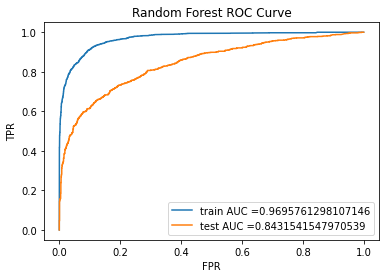

In [233]:
from sklearn.metrics import roc_curve, auc


randomForest1 = RandomForestClassifier(min_samples_leaf=2, n_estimators=1800)
randomForest1.fit(X_train_tfidf, y_train)
y_predicted = randomForest1.predict(X_test_tfidf)


train_fpr, train_tpr, thresholds = roc_curve(y_train,randomForest1.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test,randomForest1.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Random Forest ROC Curve")
plt.show()

In [218]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,randomForest1.predict(X_test_tfidf))

0.7805194805194805

In [219]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math

MSE = mean_squared_error(y_test, y_predicted)
 
RMSE = math.sqrt(MSE)
MAE = mean_absolute_error(y_test, y_predicted)
r2 = r2_score(y_test, y_predicted)
print("Root Mean Square Error: ", RMSE)
print("MSE: ", MSE)
print("MAE:", MAE)
print("R2 score:", r2)

Root Mean Square Error:  0.46848748060169065
MSE:  0.21948051948051947
MAE: 0.21948051948051947
R2 score: 0.09265154432152822


In [220]:
sub = pd.read_csv('sample_submission.csv')
sub.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [221]:
prediction = randomForest1.predict(final_test_tf_idf)

In [222]:
pred['id'] = sub['id']
pred['target'] = prediction.astype(int)

pred.to_csv('submission.csv', index=False)

### 2. SVM

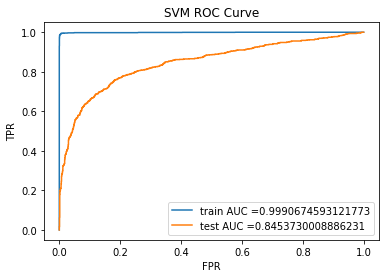

In [235]:
from sklearn import svm
from sklearn.metrics import roc_curve, auc
# clf = svm.SVC(kernel='linear', random_state=1, gamma=0.05, C=5)
clf = svm.SVC(max_iter=5000, tol=1e-8,random_state=42, probability=True)
clf.fit(X_train_tfidf, y_train)
y_pred = clf.predict(X_test_tfidf)

train_fpr, train_tpr, thresholds = roc_curve(y_train,clf.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test,clf.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("SVM ROC Curve")
plt.show()

In [228]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math
from sklearn.metrics import accuracy_score

acc = metrics.accuracy_score(y_test, y_pred)

MSE_d = mean_squared_error(y_test, y_pred)
 
RMSE_d = math.sqrt(MSE_d)
MAE_d = mean_absolute_error(y_test, y_pred)
r2_d = r2_score(y_test, y_pred)

print("Accuracy (default):", acc)
print("Root Mean Square Error (Default): ", RMSE_d)
print("MSE (Default): ", MSE_d)
print("MAE (Default):", MAE_d)
print("R2 score (Default):", r2_d)

Accuracy (default): 0.7792207792207793
Root Mean Square Error (Default):  0.4698714938993648
MSE (Default):  0.22077922077922077
MAE (Default): 0.22077922077922077
R2 score (Default): 0.08930261034118114


In [229]:
y_pred

array([0, 1, 1, ..., 0, 1, 0])

In [230]:
sub = pd.read_csv('sample_submission.csv')
sub.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [236]:
prediction = clf.predict(final_test_tf_idf)

In [238]:
pred['id'] = sub['id']
pred['target'] = prediction.astype(int)

pred.to_csv('submission.csv', index=False)

### 3. Decision Tree

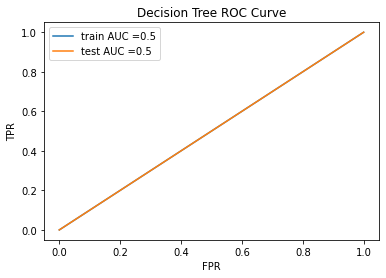

In [234]:
from sklearn.tree import DecisionTreeClassifier
# clf = DecisionTreeClassifier(random_state=0)
DT = DecisionTreeClassifier(min_samples_split= 10, min_samples_leaf= 5, max_features= 3, max_depth= 80)
DT = DT.fit(X_train_tfidf,y_train)
y_pred = DT.predict(X_test_tfidf)

train_fpr, train_tpr, thresholds = roc_curve(y_train,DT.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test,DT.predict_proba(X_test_tfidf)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("Decision Tree ROC Curve")
plt.show()

In [66]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import math
from sklearn.metrics import accuracy_score

acc = metrics.accuracy_score(y_test, y_pred)

MSE_d = mean_squared_error(y_test, y_pred)
 
RMSE_d = math.sqrt(MSE_d)
MAE_d = mean_absolute_error(y_test, y_pred)
r2_d = r2_score(y_test, y_pred)

print("Accuracy (default):", acc)
print("Root Mean Square Error (Default): ", RMSE_d)
print("MSE (Default): ", MSE_d)
print("MAE (Default):", MAE_d)
print("R2 score (Default):", r2_d)

Accuracy (default): 0.5978354978354978
Root Mean Square Error (Default):  0.6341644125654656
MSE (Default):  0.40216450216450217
MAE (Default): 0.40216450216450217
R2 score (Default): -0.6727009413468505
